In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics

import torch
import torch.nn.functional as F

In [9]:
# Total number of columns in the dataset = 36
required_cols = list(range(36))

# Read the dataset
raw_data = pd.read_excel("Jae-Second_Exp_data.xlsx",
                     sheet_name="Analysis_summary",
                     nrows=161,
                     usecols = required_cols)

# Print the data info
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Subject                             161 non-null    int64  
 1   Screen_size                         161 non-null    object 
 2   Task_num                            161 non-null    object 
 3   Time_to_firstclick                  161 non-null    float64
 4   Log_timetoF                         161 non-null    float64
 5   Fixation_count                      161 non-null    int64  
 6   Fixation_loss                       161 non-null    int64  
 7   Mean_fixation_duration              161 non-null    float64
 8   Loag_Fixationtime                   161 non-null    float64
 9   Task_completion_duration            161 non-null    float64
 10  Log_completionD                     161 non-null    float64
 11  Page_visit                          161 non-n

### Observations

1. Most of the features are of numerical types (float, int). The only exceptions are **Screen_size, task_num** which are categorical features with 3 and 9 distinct categories each.
2. **Skip_distance** and **Regression_distance** contain missing values. However, these missing values aren't random. Missing values in these two columns occur in correspondance with 0 values in Skip, Skip_count, Regression and Regression_count.
3. The feature "Subject" is as an identifier column.


Now we will further inspect the relations between the independent variables

### Identify feature correlations (independent variables)

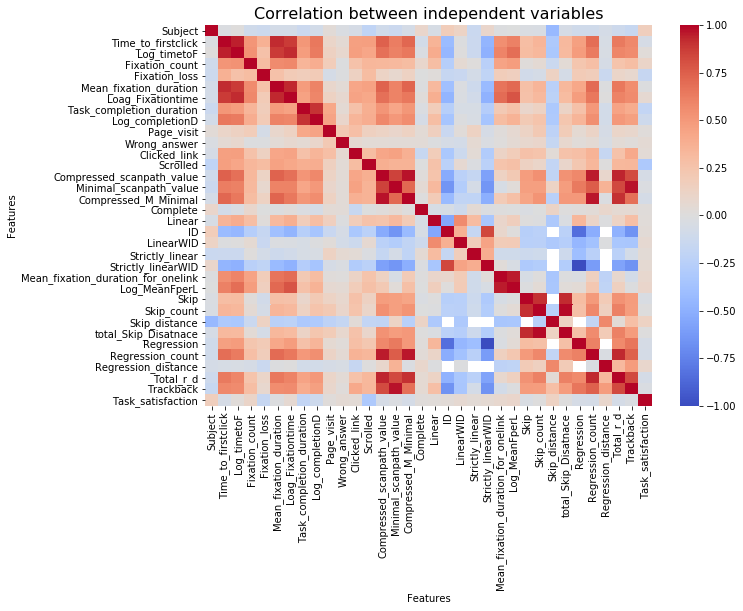

In [10]:
# Get the correlation matrix for numerical data
num_data = raw_data.drop(["Screen_size", "Task_num"], axis=1)
corr = num_data.corr()

# Plot a heatmap for the correlation matrix
fig, ax = plt.subplots(figsize=(10,7))

sns.heatmap(corr, ax=ax, cmap='coolwarm')  
ax.set_title("Correlation between independent variables", fontsize=16)
ax.set_xlabel("Features")
ax.set_ylabel("Features")
plt.show()

There are evidently many highly correlated pairs. However, it's very difficult to make a note of them without getting distracted because of the high number of features. 

**Let's highlight the most correlated pairs (positive and negative alike)**.

We'll consider a Pearson correlation of 0.85 and above as "High Correlation".

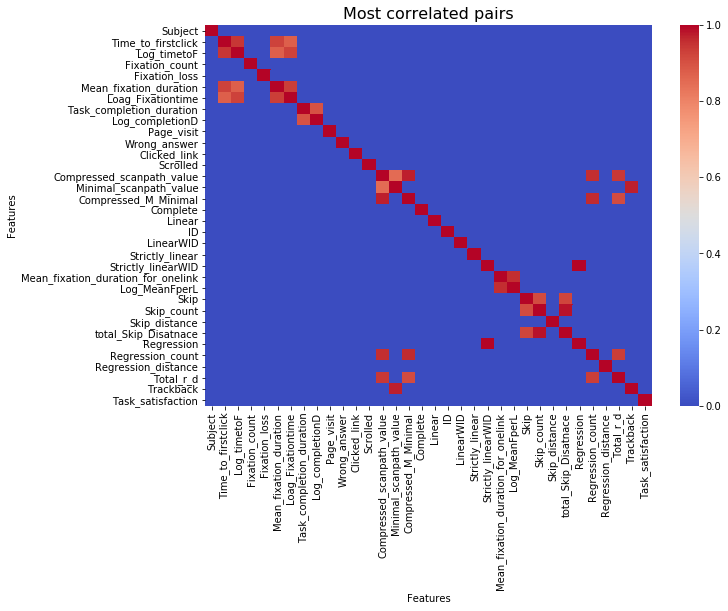

In [11]:
abs_corr = np.abs(corr) # Treat positive and negative correlation as the same using np.abs()

# Highest correlation pairs
high_corr = abs_corr[abs_corr >= 0.85]

# Plot a heatmap for the correlation matrix
fig, ax = plt.subplots(figsize=(10,7))

sns.heatmap(high_corr.fillna(0), ax=ax, cmap='coolwarm')
plt.title("Most correlated pairs", fontsize=16)
ax.set_xlabel("Features")
ax.set_ylabel("Features")
plt.show()

##### Highly Correlated Variables (corr >= 0.85):

1. Time_to_firstclick, Mean_fixation_duration, Loag_fixation_time and Log_timetoF with each other.
2. Task_completion_duration and Log_completionD.
3. Regression_count, Compressed_scanpath_value, Total_r_d and Compressed_M_Minimal with each other.
4. Strictly_linearWID and Regression have correlation **-1**. 
5. Mean_fixation_duration_for_onelink and Log_MeanFperL.
6. Skip, Skip_count and total_Skip_Disatnace with each other.


In [12]:
## Uncomment below code to verify high correlation variables

# for col in high_corr:
#     print()
#     print(col,": \n",high_corr[col].dropna())

### Preprocessing Steps

1. For now, we will just replace the missing values with 0 in the Regression_distance column. 
2. We will remove the entire Skip_distance column since it has more than 80% missing data.
3. Also, we will remove the column "Subject" since it is an identifier column, thus not necessary for the modelling process.
4. Encode Task_num using Categorical dummy features. *(All 0s in Task_num will correspond to t9 to avoid the dummy variable trap)*.
5. Retain only one of the the highly correlated variables (preferably one with highest correlation, in case more than two variables), to minimise redundant information and reduce input size.

Following the criteria above we will remove the following columns:
- Mean_fixation_duration
- Loag_fixation_time
- Log_timetoF
- Task_completion_duration
- Compressed_scanpath_value
- Total_r_d 
- Compressed_M_Minimal
- Strictly_linearWID
- Mean_fixation_duration_for_onelink 
- Skip 
- Skip_count

6. Encode the Target Variable, "Screen_size" as 0, 1, 2 for S, M, L respectively.

In [67]:
def preprocess_data(raw_data):
    
    # Add categorical dummy variables (All 0s represent)
    tasknum_dummies = pd.get_dummies(raw_data['Task_num'],
                                     prefix="TaskNum") # Create dummy variables
    data = pd.concat([raw_data, tasknum_dummies], axis=1) 

    # Remove the unnecessary columns
    remove_cols = ["Skip_distance",
              "Subject",
              "Mean_fixation_duration",
              "Loag_Fixationtime",
              "Log_timetoF",
              "Task_completion_duration",
              "Compressed_scanpath_value", 
              "Total_r_d",
              "Compressed_M_Minimal",
              "Strictly_linearWID",
              "Mean_fixation_duration_for_onelink",
              "Skip",
              "Skip_count", 
              "Task_num",
              "TaskNum_t9"]  # Remove one dummy variable to avoid the dummy variable trap

    data = data.drop(remove_cols, axis=1)
    
    # Encode the Screen_size column
    vals = ['S', 'M', 'L']
    for i in range(len(vals)):
        data.at[data['Screen_size'] == vals[i], ['Screen_size']] = i    

    # Replace missing values with 0 in column Regression_distance
    preprocessed_data = data.fillna(0)

    # Inspect the number of missing values in the preprocessed_data dataset
    num_missing = preprocessed_data.isnull().sum().sum()
    print("The number of missing values in the data = {}".format(num_missing))
    print("Number of features remaining = {}".format(data.shape[1]))
    
    return preprocessed_data

data = preprocess_data(raw_data = raw_data)

The number of missing values in the data = 0
Number of features remaining = 30


## Modelling

*1. Split the data into training and test sets*

In [68]:
# Divide into features and target variables
X = data.drop("Screen_size", axis=1)
y = data['Screen_size']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

*2. Create the Simple Neural Network*

In [94]:
def create_model(hidden_neurons, learning_rate, num_epoch, input_neurons = X.shape[1], output_neurons=3):
    
    # define the structure of our neural network
    net = torch.nn.Sequential(
        torch.nn.Linear(input_neurons, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, hidden_neurons),
        torch.nn.Sigmoid(),
        torch.nn.Linear(hidden_neurons, output_neurons),
    )

    # define loss functions
    loss_func = torch.nn.CrossEntropyLoss()

    # define optimiser
    optimiser = torch.optim.SGD(net.parameters(), lr=learning_rate)
    
    return net, loss_func, optimiser

# define the number of neurons for hidden layer and define learning rate and number of epoch on training
hidden_neurons = 32
learning_rate = 0.474
num_epoch = 200

# Create a simple neural network
net, loss_func, optimiser = create_model(hidden_neurons=hidden_neurons,
                                         learning_rate=learning_rate,
                                         num_epoch=num_epoch)

*3. Train the Simple Neural Network*

In [95]:
def train_neural_network(model, X_train, y_train):
    
    # create Tensors to hold inputs and outputs. Tensors are data structures
    # similar to numpy matrices. They can be operated on efficiently by a GPU
    # 
    # Note: In torch versions before 0.4, Tensors had to be wrapped in a Variable
    # to be used by the NN.
    X = torch.tensor(X_train.values, dtype=torch.float)
    Y = torch.tensor(y_train.values, dtype=torch.long)
    
    
    # store all losses for visualisation
    all_losses = []

    # train a neural network
    for epoch in range(num_epoch):
        # Perform forward pass: compute predicted y by passing x to the model.
        # Here we pass a Tensor of input data to the Module and it produces
        # a Tensor of output data.
        # In this case, Y_pred contains three columns, where the index of the
        # max column indicates the class of the instance
        Y_pred = net(X)

        # Compute loss
        # Here we pass Tensors containing the predicted and true values of Y,
        # and the loss function returns a Tensor containing the loss.
        loss = loss_func(Y_pred, Y)
        all_losses.append(loss.item())

        # print progress
#         if epoch % 50 == 0:
#             # convert three-column predicted Y values to one column for comparison
#             _, predicted = torch.max(F.softmax(Y_pred,1), 1)

#             # calculate and print accuracy
#             total = predicted.size(0)
#             correct = predicted.data.numpy() == Y.data.numpy()

#             print('Epoch [%d/%d] Loss: %.4f  Accuracy: %.2f %%'
#                   % (epoch + 1, num_epoch, loss.item(), 100 * sum(correct)/total))

        # Clear the gradients before running the backward pass.
        net.zero_grad()

        # Perform backward pass: compute gradients of the loss with respect to
        # all the learnable parameters of the model.
        loss.backward()

        # Calling the step function on an Optimiser makes an update to its
        # parameters
        optimiser.step()
        
    return np.array(all_losses)

losses = train_neural_network(net, X_train, y_train)

*4. Evaluate the model on Trainig Data*

In [96]:
def evaluate(net, x, y, mode='Train'):
    
    # Transform data to tensors
    X = torch.tensor(x.values, dtype=torch.float)
    Y = torch.tensor(y.values, dtype=torch.long) 

    # Create empty 3x3 confusion matrix
    confusion = torch.zeros(3, 3)

    # Make predictions on X
    Y_pred = net(X)
    _, predicted = torch.max(F.softmax(Y_pred,1), 1)

    # Create confusion Matrix
    for i in range(X.shape[0]):
        actual_class = Y.data[i]
        predicted_class = predicted.data[i]

        confusion[actual_class][predicted_class] += 1

    # Calculate Accuracy score
    correct_pred_count = confusion[0,0] + confusion[1,1] + confusion[2,2]
    accuracy_score = correct_pred_count / confusion.sum() * 100

    print("{}ing Accuracy = {}%".format(mode, accuracy_score))    
    print('Confusion matrix for {}ing:'.format(mode))
    print(confusion.numpy())
    
    print("\nClassification Report -")
    print(metrics.classification_report(y, predicted.numpy()))
    
evaluate(net, X_train, y_train)

Training Accuracy = 52.34375%
Confusion matrix for Training:
[[31.  7.  5.]
 [14. 22.  7.]
 [17. 11. 14.]]

Classification Report -
              precision    recall  f1-score   support

           0       0.50      0.72      0.59        43
           1       0.55      0.51      0.53        43
           2       0.54      0.33      0.41        42

    accuracy                           0.52       128
   macro avg       0.53      0.52      0.51       128
weighted avg       0.53      0.52      0.51       128



*5. Evaluate on Test Data*

In [97]:
evaluate(net, X_test, y_test, mode='Test')

Testing Accuracy = 54.54545593261719%
Confusion matrix for Testing:
[[8. 2. 1.]
 [5. 5. 1.]
 [5. 1. 5.]]

Classification Report -
              precision    recall  f1-score   support

           0       0.44      0.73      0.55        11
           1       0.62      0.45      0.53        11
           2       0.71      0.45      0.56        11

    accuracy                           0.55        33
   macro avg       0.59      0.55      0.54        33
weighted avg       0.59      0.55      0.54        33



In [73]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

preds = clf.predict(X_test)

print(metrics.classification_report(preds, y_test))

              precision    recall  f1-score   support

           0       0.36      0.57      0.44         7
           1       0.64      0.33      0.44        21
           2       0.27      0.60      0.37         5

    accuracy                           0.42        33
   macro avg       0.42      0.50      0.42        33
weighted avg       0.52      0.42      0.43        33

